In [1]:
from flatland.envs.rail_generators import complex_rail_generator, rail_from_manual_specifications_generator, random_rail_generator , sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, sparse_schedule_generator
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from flatland.envs.observations import TreeObsForRailEnv,GlobalObsForRailEnv,LocalObsForRailEnv
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.utils.ordered_set import OrderedSet
from flatland.core.grid.grid4_utils import get_new_position,get_direction
from flatland.envs.schedule_utils import Schedule
from flatland.core.grid.grid4 import Grid4TransitionsEnum

import math
import numpy as np
import time
import random
from MappedQueue import PriorityQueue

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
def environment1 ():
    random.seed(1)
    np.random.seed(1)
    NUMBER_OF_AGENTS = 20
    env = RailEnv(
                width=20,
                height=20,
                rail_generator=complex_rail_generator(
                                        nr_start_goal=20,
                                        nr_extra=1,
                                        min_dist=8,
                                        max_dist=99999,
                                        seed=0),
                schedule_generator=complex_schedule_generator(),
                number_of_agents=NUMBER_OF_AGENTS)
    return env


In [4]:
def random_environment ():
    random.seed(1)
    np.random.seed(1)
    NUMBER_OF_AGENTS = 15
    transition_probability = [1.0,  # empty cell - Case 0
                          1.0,  # Case 1 - straight
                          1.0,  # Case 2 - simple switch
                          0.3,  # Case 3 - diamond drossing
                          0.5,  # Case 4 - single slip
                          0.5,  # Case 5 - double slip
                          0.2,  # Case 6 - symmetrical
                          0.0,  # Case 7 - dead end
                          0.2,  # Case 8 - turn left
                          0.2,  # Case 9 - turn right
                          1.0]  # Case 10 - mirrored switch

    # Example generate a random rail
    env = RailEnv(width=10,
                  height=10,
                  rail_generator=random_rail_generator(
                            cell_type_relative_proportion=transition_probability
                            ),
                  number_of_agents=NUMBER_OF_AGENTS )
    return env

In [5]:
def sparse_env ():
    random.seed(1)
    np.random.seed(1)
    NUMBER_OF_AGENTS = 100
    rail_generator = sparse_rail_generator(
                        max_num_cities=20,
                        grid_mode=False,
                        max_rails_between_cities=2,
                        max_rails_in_city=8,
                        seed = 14
                    )

    #Build the environment
    env = RailEnv(
        width=50,
        height=50,
        rail_generator=rail_generator,
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=NUMBER_OF_AGENTS
    )
    return env

In [6]:
env = random_environment()
env_renderer = RenderTool(env ,screen_width=1600 , screen_height=750 , show_debug=True )
obs , info = env.reset()
env_renderer.render_env(show=True , frames = True , show_observations = False , show_predictions=False )

In [7]:
def heuristic(a , b , agent):
    (x1, y1) = a
    (x2, y2) = b
    
    if (b == (-1,-1) ):
        (x2,y2) = agent.initial_position 
        return abs(x1 - x2) + abs(y1 - y2) + 1 
    else:
        return abs(x1 - x2) + abs(y1 - y2)

In [8]:
def get_new_position_direction (position , direction , agent):
    '''
        This will return the new position and direction
        along the action ['Left' , 'Forward' , 'Right' , 'Stop']
    '''
    
    if (position == (-1,-1)):
        transitions = []
        
        #this corresponds to movind forward
        transitions.append((agent.initial_position , agent.initial_direction))

        #this corresponds to remaining where it is
        transitions.append(((-1,-1) , -1))
        
        return transitions
        
        
    cell_transitions = env.rail.get_transitions(*position, direction)
    transition_bit = bin(env.rail.get_full_transitions(*position))
    total_transitions = transition_bit.count("1")

    crossing_found = False
    if int(transition_bit, 2) == int('1000010000100001', 2):
        crossing_found = True

    if crossing_found:
        total_transitions = 2
    num_transitions = np.count_nonzero(cell_transitions)
    
    last_is_dead_end = False
    if num_transitions == 1:
        nbits = total_transitions
        if nbits == 1:
            last_is_dead_end = True

    possible_transitions = env.rail.get_transitions(*position, direction)
    
    transitions = []
    
    
    for i , branch_direction in enumerate([(direction + 4 + i) % 4 for i in range(-1, 2)]):
        if last_is_dead_end and env.rail.get_transition((*position, direction),
                                                                 (branch_direction + 2) % 4):
            
            new_cell = get_new_position(position, (branch_direction + 2) % 4)
            transitions.append((new_cell , (branch_direction + 2) % 4))
        
        elif possible_transitions[branch_direction]:
            new_cell = get_new_position(position, branch_direction)
            transitions.append((new_cell , branch_direction))
        
        else:
            transitions.append(None)
    
    #last one is for stop action
    transitions.append((position , direction))
    
    return transitions

In [9]:
max_steps = int(4 * 2 * (20 + env.height + env.width))
time_reserved = {}
action_trajectories = {}
path_trajectories = {}
number_of_agents = env.number_of_agents


In [10]:
def intialise_cooperative_A_star():
    
    for i in range(1,max_steps+1):
        time_reserved[i] = OrderedSet()

        
    for i in range(number_of_agents):
        action_trajectories[i] = []
        path_trajectories[i] = []   
        
#         agent = env.agents[i]
#         time_reserved[1].add(agent.initial_position)

In [11]:
def position_empty(time , position):

    if (position == (-1,-1)):
        return True
    
    if position in time_reserved[time]:
        return False
    else:
        return True

In [12]:
def reconstruct_path (came_from , cost_so_far , goal , agent):
    current = None , None
    min_cost = 10000
    for keys, values in cost_so_far.items():
        if keys[0] == goal and values < min_cost and not came_from[keys][0][0] == (-1,-1) and not came_from[keys][0][0] == agent.initial_position:
            current = keys
            min_cost = values

    current_action = 0
    path = []
    while current is not None:
        path.append((current , current_action))
        current_action = came_from[current][1]
        current = came_from[current][0]
    #     current_pos , current_direction = came_from[current_pos , current_direction]

    path.reverse()
    return path

In [13]:
def fill_action_trajectory (agent_handle , path):

    for _,x in path:
        if (x == -1): #do nothing
            action_trajectories[agent_handle].append(0)
        if (x == 0):         #left
            action_trajectories[agent_handle].append(1)
        elif (x == 1):         #forward  
            action_trajectories[agent_handle].append(2)
        elif (x == 2):         #right 
            action_trajectories[agent_handle].append(3)
        elif(x==3):            #stop
            action_trajectories[agent_handle].append(4)
        
        
    while not (len(action_trajectories[agent_handle]) == max_steps):
        action_trajectories[agent_handle].append(4)

In [14]:
def reserve_path (path):
    for i in range(len(path)):
        x,action = path[i]
        position , direction , time = x
        if (position == (-1,-1)):
            continue
            
        time_reserved[time].add(position)
        time_reserved[time+1].add(position)
        

In [15]:
def mark_trajectory (agent_handle , path):
    
    visited = OrderedSet()
    
    for i in range(len(path)):
        x,action = path[i]
        position , direction , time = x
        if not (position == (-1,-1)):
            visited.add(position)
        path_trajectories[agent_handle].append(position)
        
    env.dev_obs_dict[agent_handle] = visited

In [16]:
intialise_cooperative_A_star()

In [17]:
env.number_of_agents

15

In [18]:
#implementing A*
#state space is ((x,y) , orientation)
def A_star (agent):

    start = ((-1,-1) , -1 , 0)         #third value is time step
    goal = agent.target

    frontier = PriorityQueue()
    frontier.put(start , 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = (None,None)
    cost_so_far[start] = 0
    explored = set()
    
    solution_found = False
    
    while not frontier.empty():
        
        
        current = frontier.get()
        position , direction , time = current


        if position == goal and not came_from[current][0][0] == (-1,-1) and not came_from[current][0][0] == agent.initial_position:
#             print(came_from[current][0][0])
            solution_found = True
            break

        explored.add (current)

        if (position == (-1,-1)):
            transitions = get_new_position_direction (position , direction ,agent)
            for i, d in enumerate(transitions):
                
                new_position , new_direction = d
                #if the new position is not empty at the given time
                if position_empty(time+1 , new_position) == False or position_empty(time + 2 , new_position) == False:
                    continue

                new_cost = cost_so_far[current] + 1
                next = (new_position , new_direction , time+1)

                if next not in cost_so_far or new_cost < cost_so_far[next]:

                    if next in explored:
                        continue

                    cost_so_far[next] = new_cost
                    priority = new_cost + heuristic(goal , new_position , agent)
                    frontier.put(next , priority)
                    if (i == 0):
                        came_from[next] = (current , 0)
                    elif(i == 1):
                        came_from[next] = (current , -1)
            
        else:
            #It corresponds to ['L' , 'F' , 'R' , 'Stop'
            transitions = get_new_position_direction (position , direction ,agent)
            for i, d in enumerate(transitions):
                if (d is not None):

                    new_position , new_direction = d
                    #if the new position is not empty at the given time
                    if position_empty(time+1 , new_position) == False or position_empty(time + 2 , new_position) == False:
                        continue

                    new_cost = cost_so_far[current] + 1
                    next = (new_position , new_direction , time+1)

                    if next not in cost_so_far or new_cost < cost_so_far[next]:

                        if next in explored:
                            continue

                        cost_so_far[next] = new_cost
                        priority = new_cost + heuristic(goal , new_position ,agent)
                        frontier.put(next , priority)
                        came_from[next] = (current , i)
                    
    return solution_found , came_from , cost_so_far

In [19]:
agent_path_found = [False] * env.number_of_agents
max_running_step = 0



for agent_handle in range(env.number_of_agents):
#     print("agent handle : " , agent_handle)
    agent = env.agents[agent_handle]
    solution_found , came_from , cost_so_far = A_star(agent)
    if solution_found:
        path = reconstruct_path(came_from , cost_so_far , agent.target , agent)
        reserve_path(path)
        fill_action_trajectory(agent_handle , path)
        
        mark_trajectory(agent_handle , path)
        max_running_step = max(max_running_step , len(path))
        agent_path_found[agent_handle] = True
        
#         if (agent_handle == 11):
#             print(came_from)
        
    else:
        for _ in range(max_steps):
            action_trajectories[agent_handle].append(0)
        
        env.dev_obs_dict[agent_handle] = OrderedSet()
            
    

In [20]:
print("Total agent able to find path : " , np.sum(agent_path_found))

Total agent able to find path :  15


In [21]:
_done = False
for step in range(max_running_step + 10):
    _action = {}
    
    for agent_handle in range(env.number_of_agents):
        _action[agent_handle] = action_trajectories[agent_handle][step]
    
    obs, all_rewards, done, _ = env.step(_action)
    _done = done['__all__']    
    if (_done):
        break
    
    
    env_renderer.render_env(show=True , frames = True , show_observations = False , show_predictions=False )
    time.sleep(0.3)
    
env_renderer.render_env(show=True , frames = True , show_observations = False , show_predictions=False )

In [22]:
total_done = 0
for keys , values in done.items():
    if not (keys == '__all__'):
        if values:
            total_done += 1
        
print(" Total_done : " , total_done)

 Total_done :  15


In [23]:
path_len = []
for i in range(env.number_of_agents):
    path_len.append(len(path_trajectories[i]))

<IPython.core.display.Javascript object>


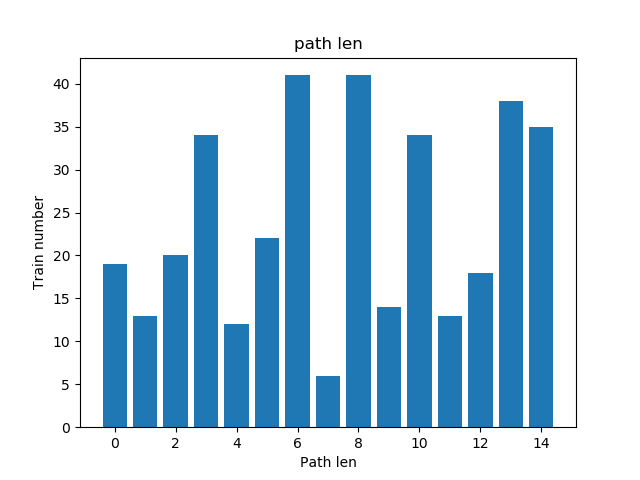

Text(0, 0.5, 'Train number')

In [24]:
plt.bar(range(env.number_of_agents) , path_len)
plt.title("path len")
plt.xlabel("Path len")
plt.ylabel("Train number")

In [25]:
for i in range(env.number_of_agents):
    print(env.agents[i].target , env.agents[i].initial_position)

(4, 7) (4, 0)
(7, 4) (5, 5)
(4, 0) (3, 5)
(0, 8) (9, 3)
(8, 4) (7, 2)
(5, 7) (7, 3)
(2, 3) (7, 5)
(5, 6) (6, 3)
(9, 2) (4, 6)
(8, 2) (7, 1)
(6, 2) (1, 6)
(6, 5) (6, 5)
(3, 5) (4, 3)
(5, 3) (0, 4)
(3, 8) (8, 7)
